In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from umap import UMAP

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *
from scroutines import pnmf
from scroutines import basicu


/home/qlyu/mambaforge/envs/bbbroutine/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sample = 'P38NR'
outdir_fig = "/scr/qlyu/projects/v1/figures"

In [3]:
adata = anndata.read(f"../../data/cheng21_cell_scrna/organized/{sample}.h5ad")
genes = adata.var.index.values
adata

AnnData object with n_obs × n_vars = 16997 × 53801
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'layer', 'Type', 'Subclass'

In [4]:
adata = adata[adata.obs['Subclass'] == 'L2/3']
types = adata.obs['Type'].values
samps = adata.obs['sample'].values
adata

View of AnnData object with n_obs × n_vars = 2697 × 53801
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'layer', 'Type', 'Subclass'

In [5]:
# use those 286 genes
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_sel = df['gene'].astype(str).values
genes_grp = df['P17on'].astype(str).values
assert len(genes_sel) == len(np.unique(genes_sel))

gi = basicu.get_index_from_array(genes, genes_sel)
assert np.all(genes_sel != -1)

# CP10k for single cells
cov = np.array(adata.X.sum(axis=1))
counts = np.array(adata.X[:,gi].todense())
norm = counts/cov*1e4
lognorm = np.log10(norm+1)
zlognorm = zscore(lognorm, axis=0) 

In [6]:
zlognorm = np.nan_to_num(zlognorm, 0)

In [7]:
gene_types, gene_type_counts = np.unique(genes_grp, return_counts=True)
gene_types, gene_type_counts

(array(['A', 'B', 'C'], dtype=object), array([122,  35, 129]))

In [8]:
pca = PCA(n_components=50)
pcs = pca.fit_transform(zlognorm)
ucs = UMAP(n_components=2, n_neighbors=50).fit_transform(pcs)

In [9]:
# fix pc1 to make sure a < c:
pc1 = pcs[:,0]
pc_types, unq_types = basicu.group_mean(pc1.reshape(-1,1), types)
a = pc_types[0,0]
c = pc_types[-1,0]
if a > c:
    pcs[:,0] = -pcs[:,0]

In [10]:
res = pd.DataFrame(pcs, columns=np.char.add("PC", ((1+np.arange(pcs.shape[1])).astype(str))))
res['type'] = types
res['samp'] = samps
res['umap1'] = ucs[:,0]
res['umap2'] = ucs[:,1]

Text(0, 0.5, 'explained var')

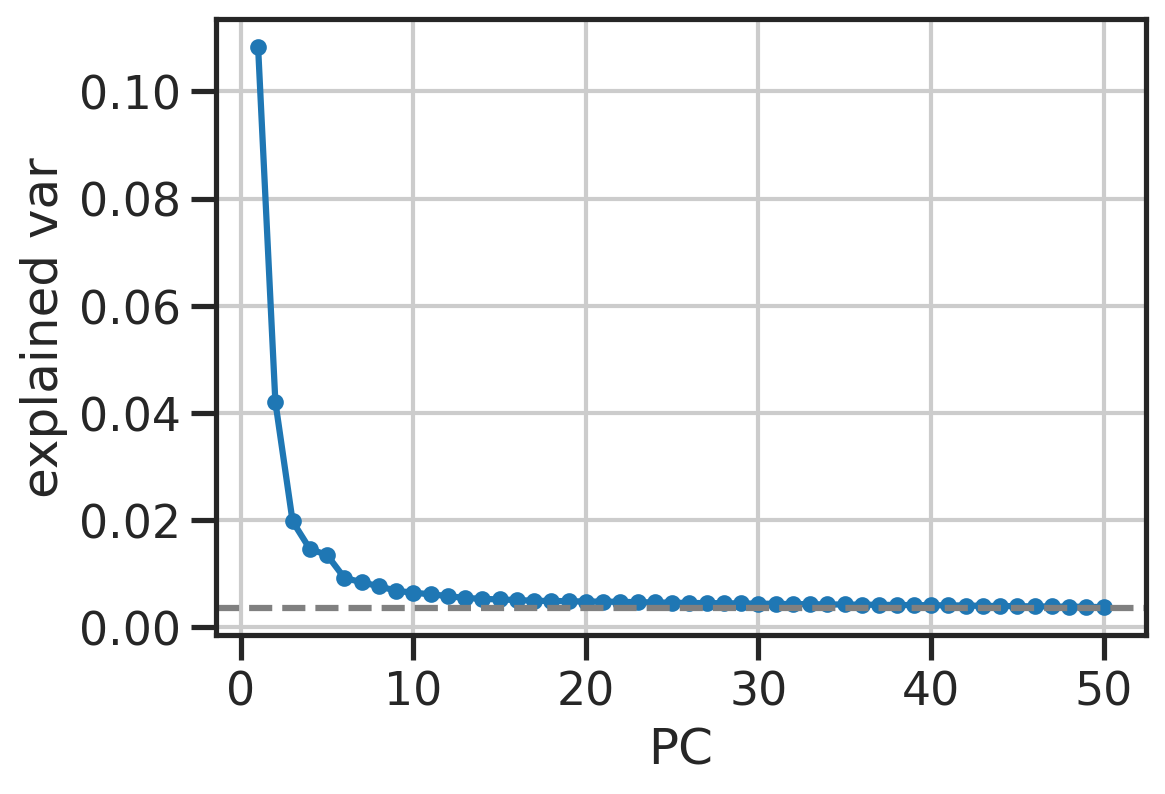

In [11]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.arange(len(pca.explained_variance_ratio_))+1, pca.explained_variance_ratio_, '-o', markersize=5)
ax.axhline(1/lognorm.shape[1], linestyle='--', color='gray')
ax.set_xlabel('PC')
ax.set_ylabel('explained var')

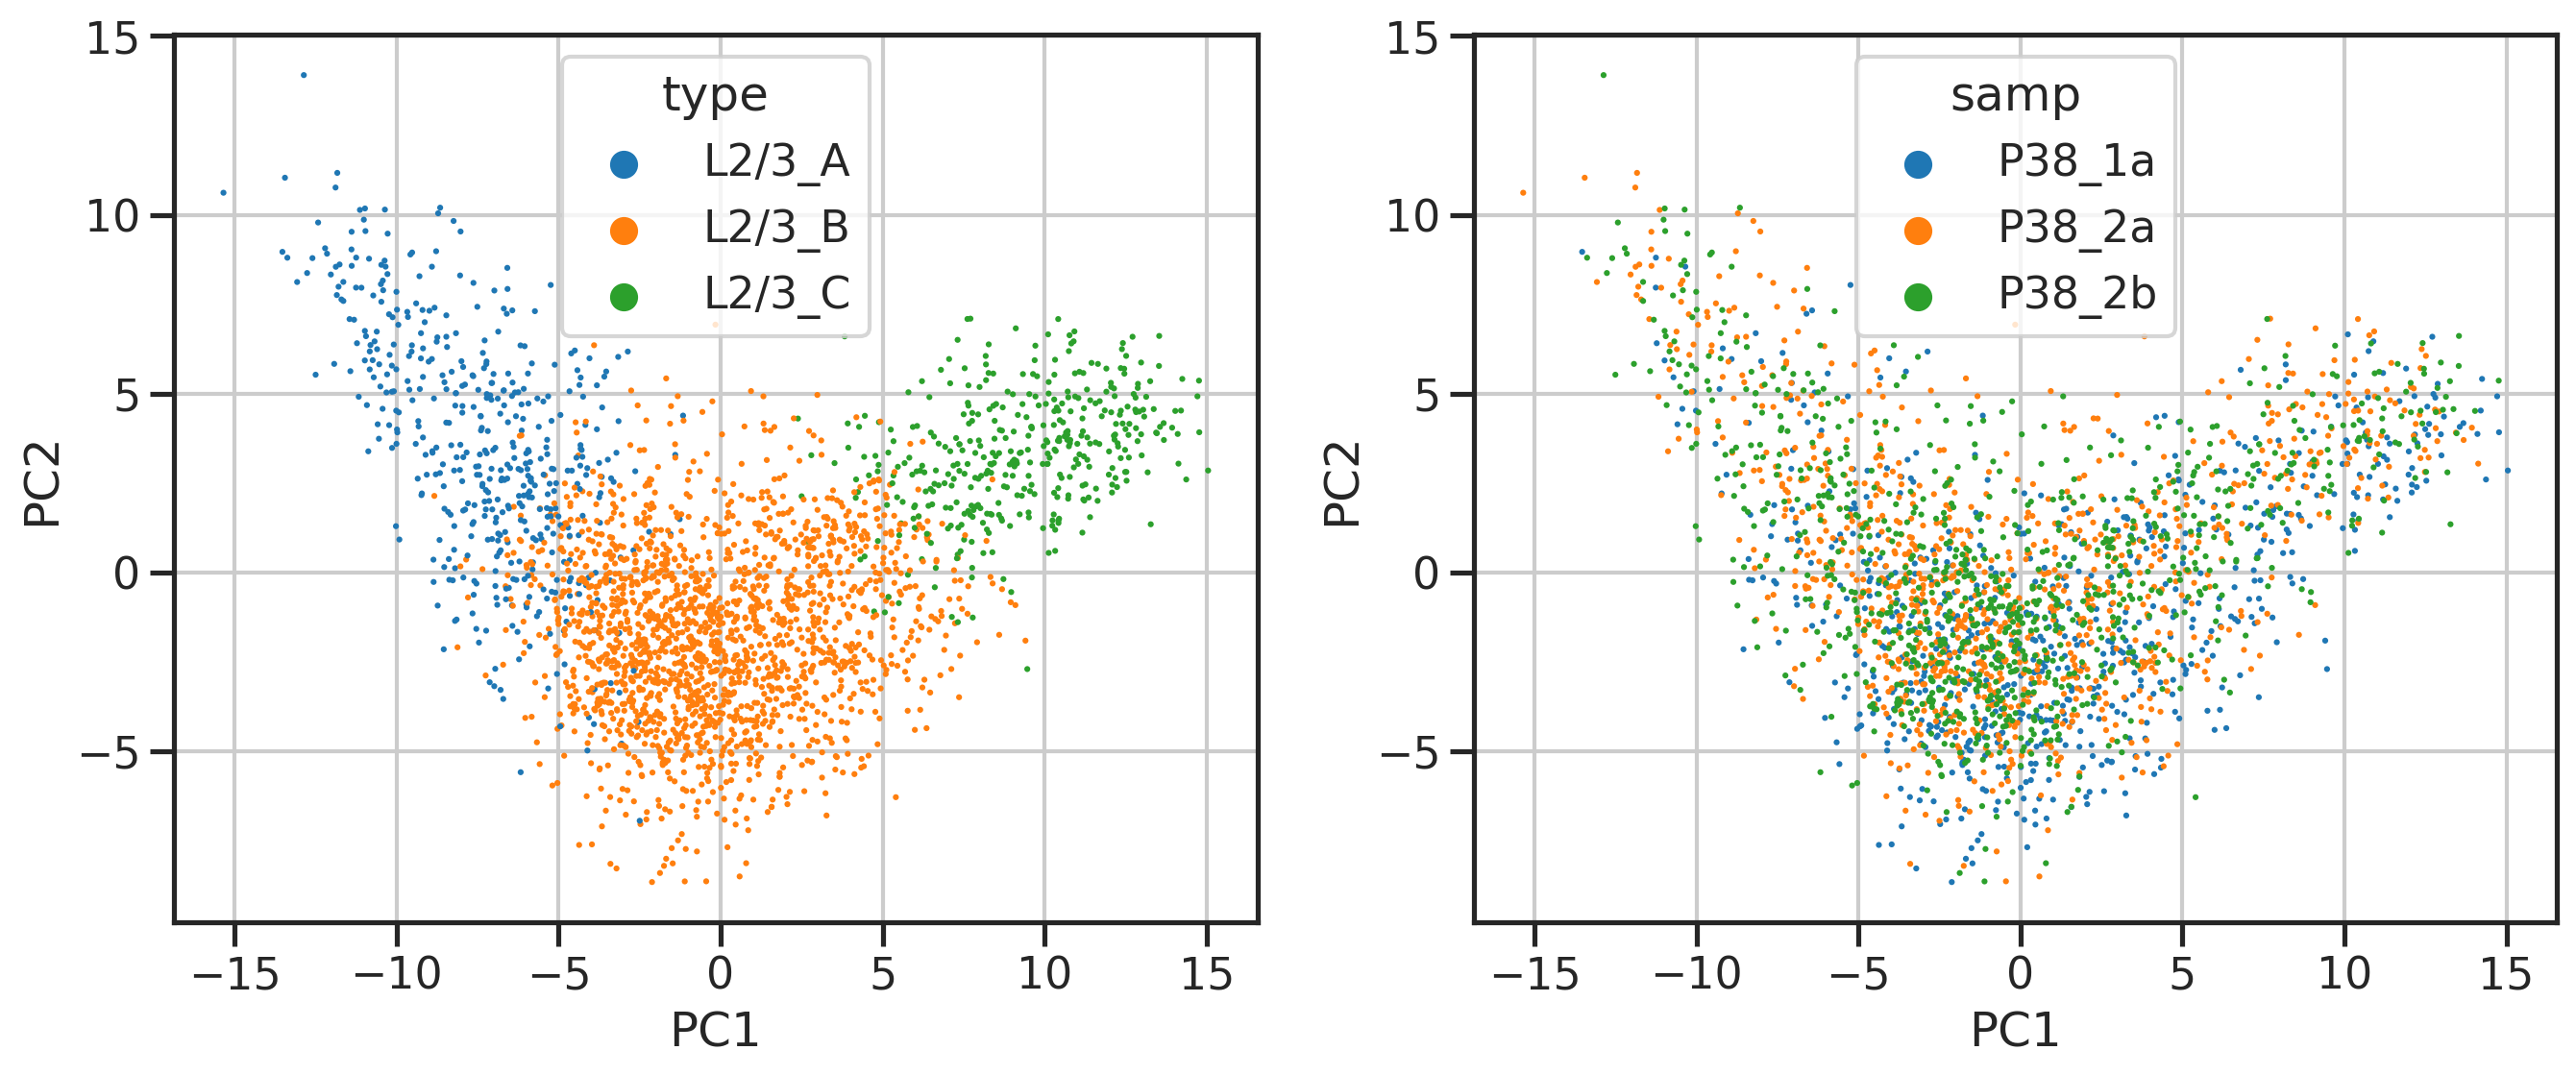

In [12]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='PC1', y='PC2', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='PC1', y='PC2', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

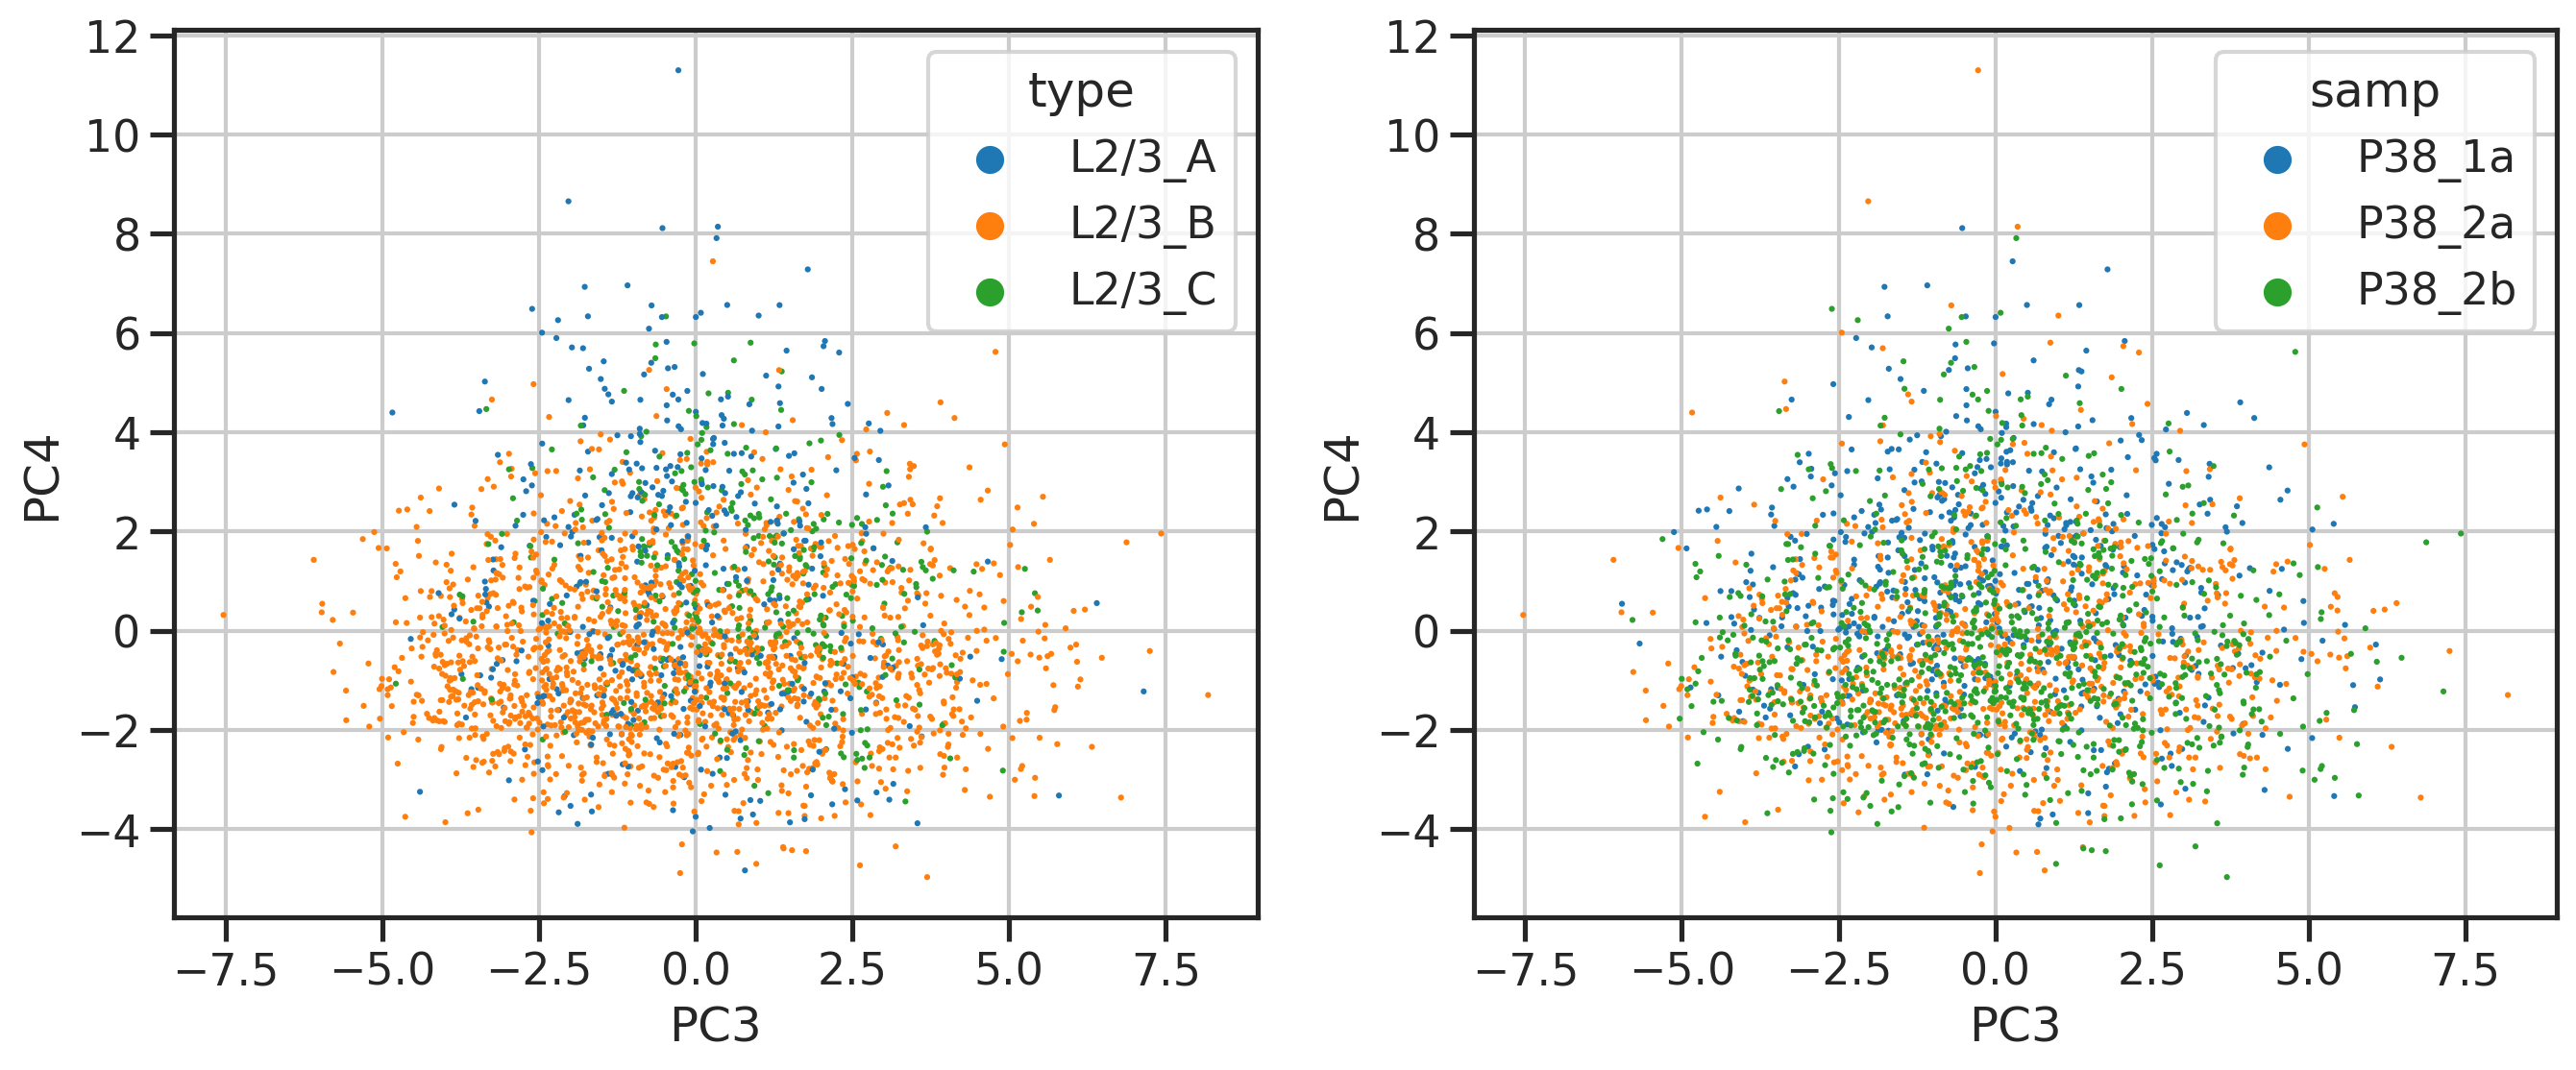

In [13]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='PC3', y='PC4', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='PC3', y='PC4', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

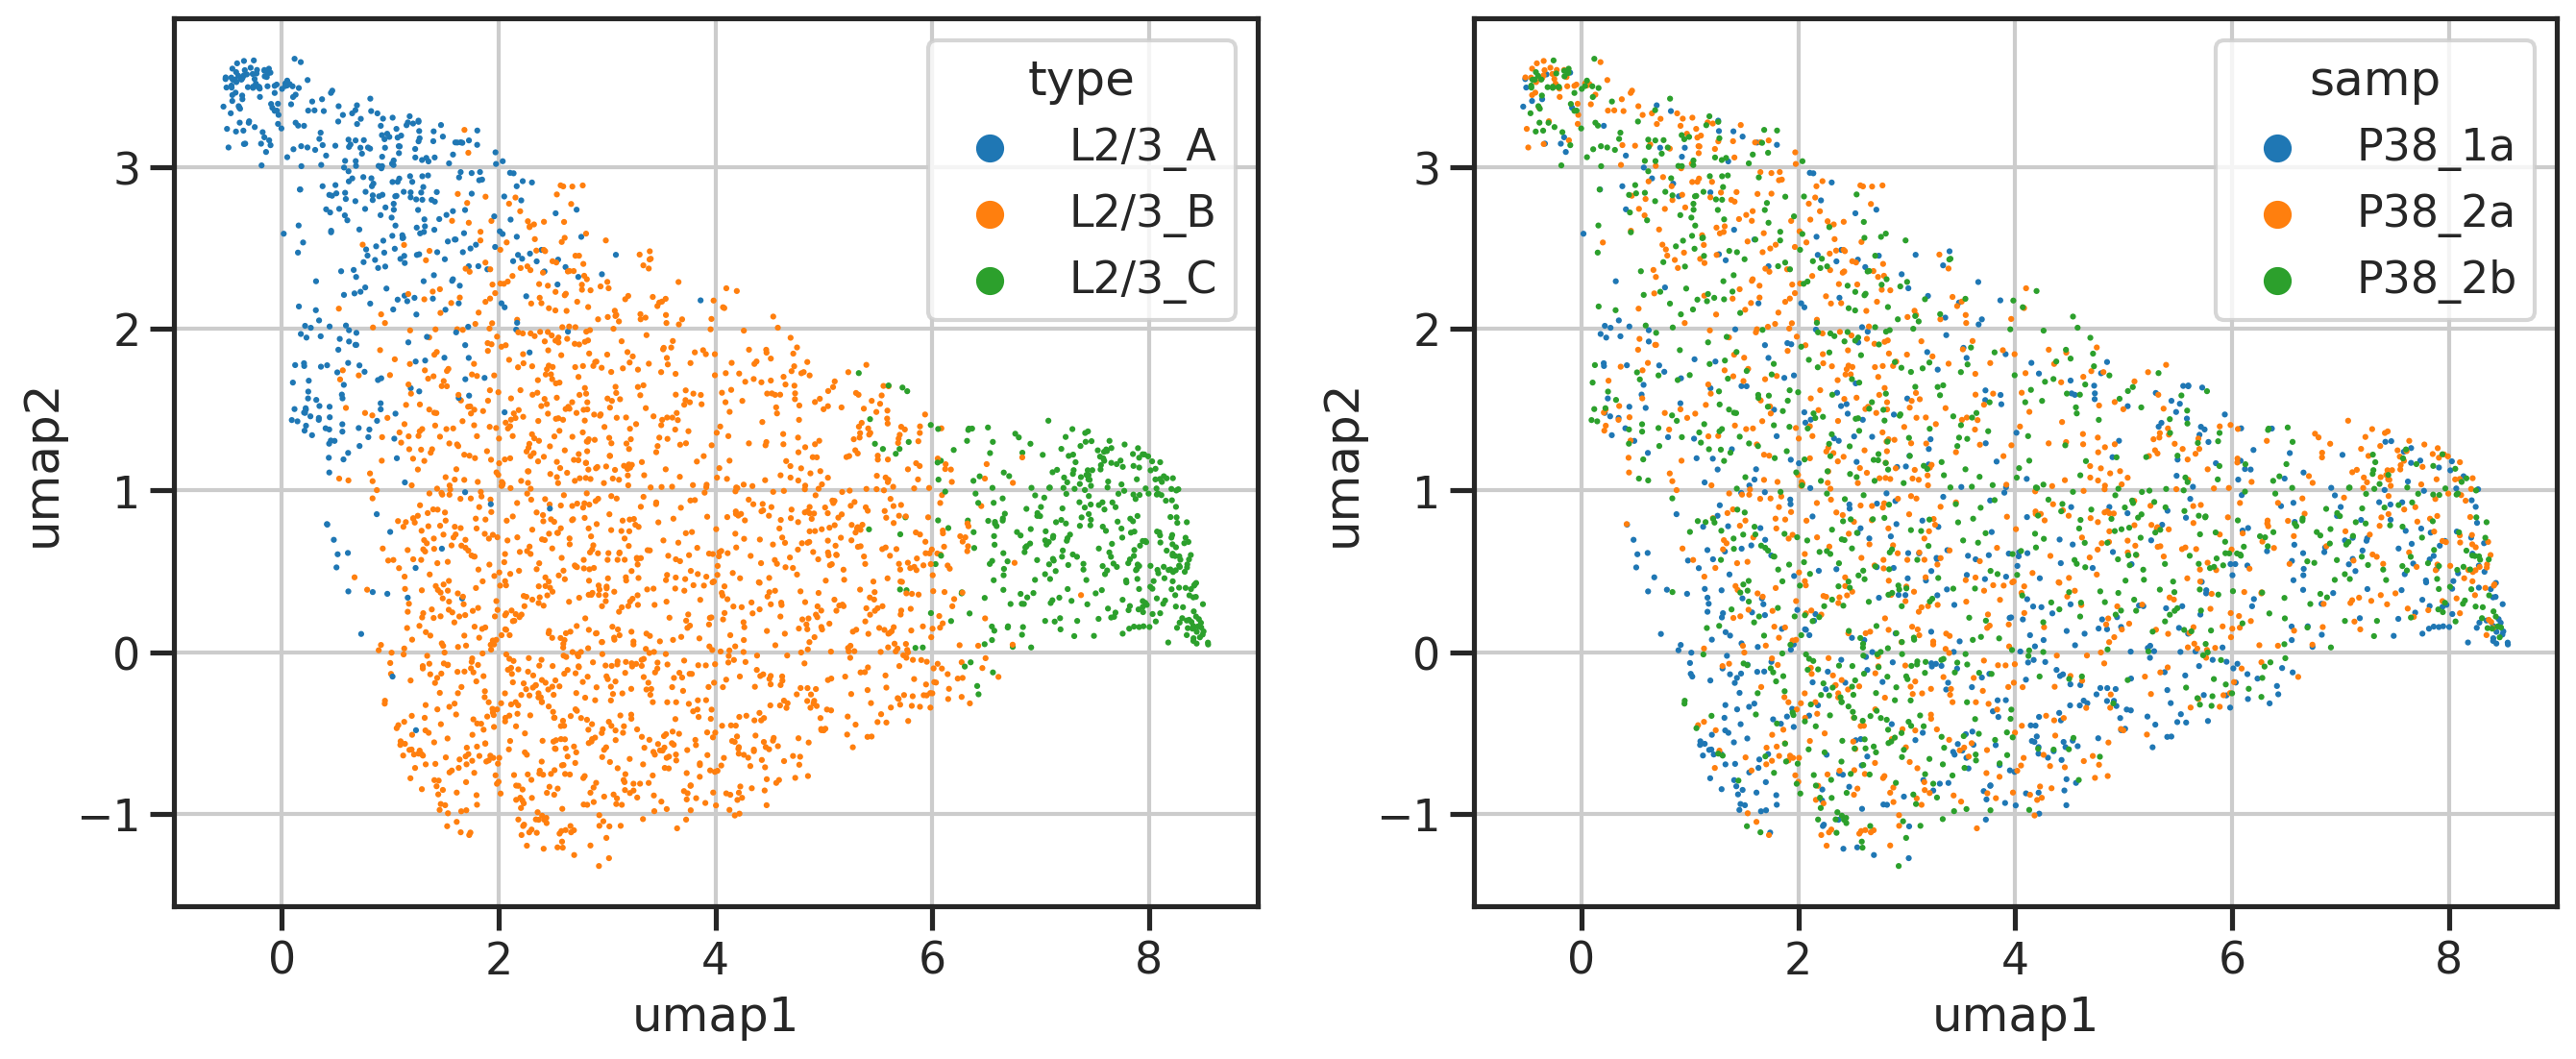

In [14]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='umap1', y='umap2', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='umap1', y='umap2', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

# heatmap

In [15]:
choices1 = sns.color_palette('tab10', 3)
choices1

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)]

In [16]:
choices2 = sns.color_palette('tab20', 20)
choices2

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [17]:
my_colors = tuple(list(choices1)) #('C0', 'C1', 'C2')
cmap_d1 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

my_colors = tuple(list(choices2[6:8])+list(choices2[14:16]))
cmap_d2 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

ncell, ngene = zlognorm.shape

In [18]:
adata.obsm['X_pca'] = pcs
sc.pp.neighbors(adata, n_neighbors=50, use_rep='X_pca')
sc.tl.diffmap(adata)
adata.uns['iroot'] = np.argmin(pcs[:,0])
sc.tl.dpt(adata)
res['ptime'] = adata.obs['dpt_pseudotime'].values

In [19]:
cellidx = np.argsort(res['ptime'].values)

# # gene ptime
# weights = ((lognorm+1e-10)/(lognorm.sum(axis=0)+1e-10))
# gptime  = res['ptime'].values.dot(weights)
# geneidx = np.argsort(gptime)

# Use P28 ordering
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt = pd.read_csv(f)
gpt = gpt['gene_ptime'].values
geneidx2 = np.argsort(gpt)

# check pseudotime (and diff map)

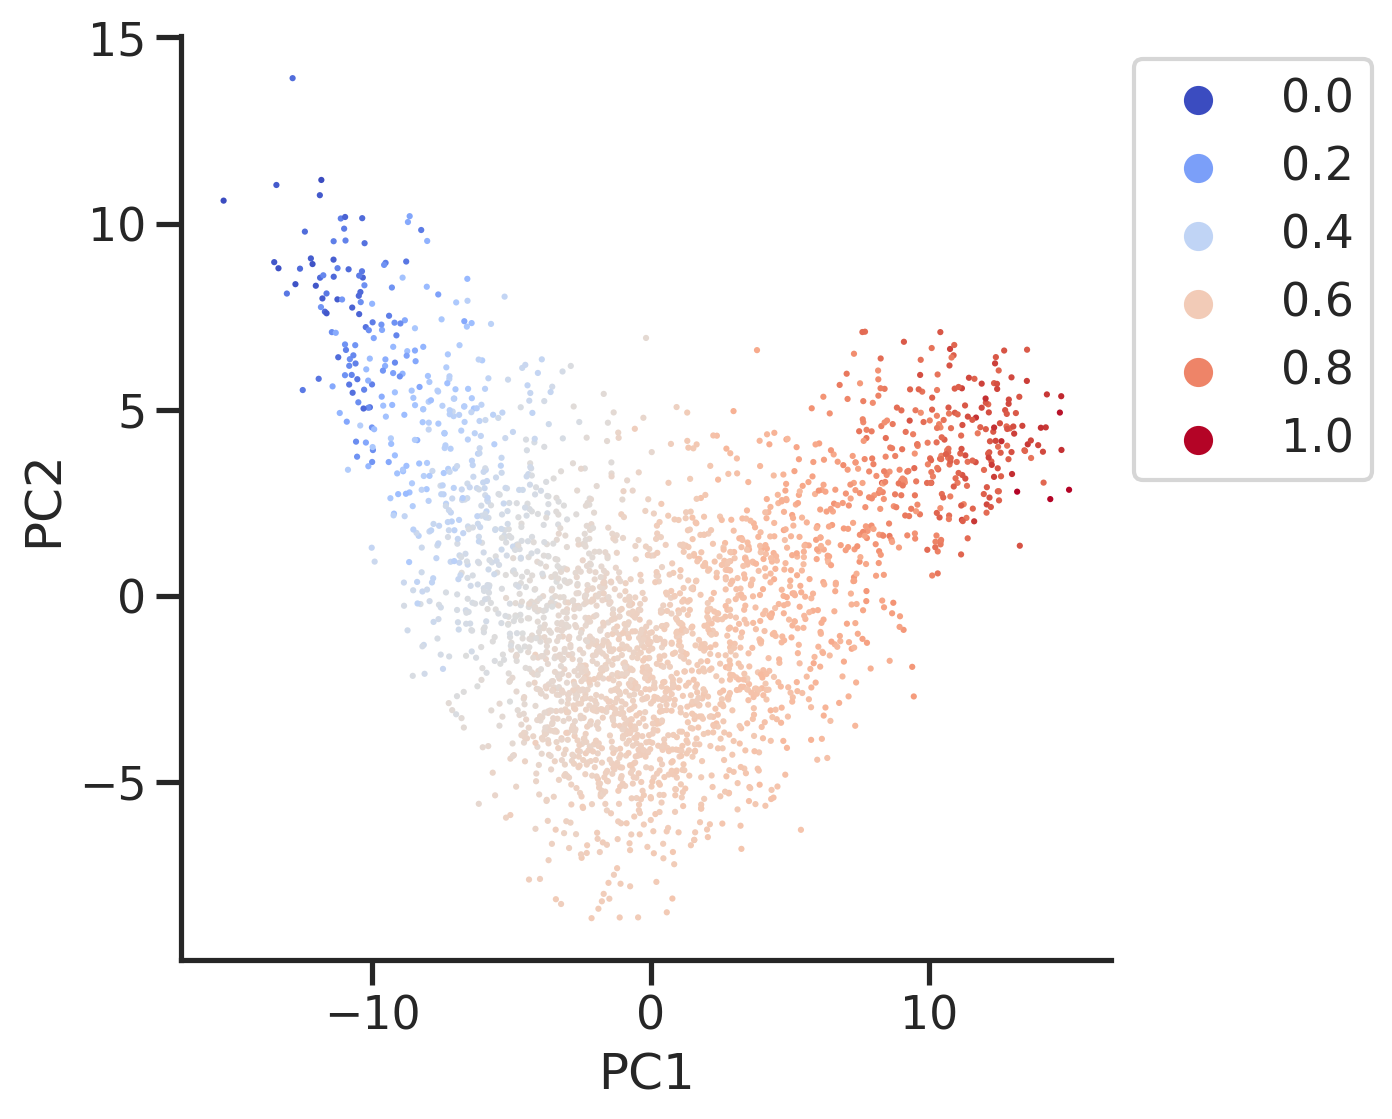

In [20]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=res, 
                x='PC1',
                y='PC2',
                hue='ptime',
                # hue_order=np.sort(adata.obs['cluster'].unique()),
                edgecolor='none',
                s=5,
                ax=ax,
                palette='coolwarm',
               )
# ax.set_xlabel(f'PC1 ({pca_v[0]*100:.1f}% var)')
# ax.set_ylabel(f'PC2 ({pca_v[1]*100:.1f}% var)')

ax.legend(bbox_to_anchor=(1,1), loc='upper left')
sns.despine(ax=ax)
ax.grid(False)
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
plt.show()

03-28 14:05:47 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


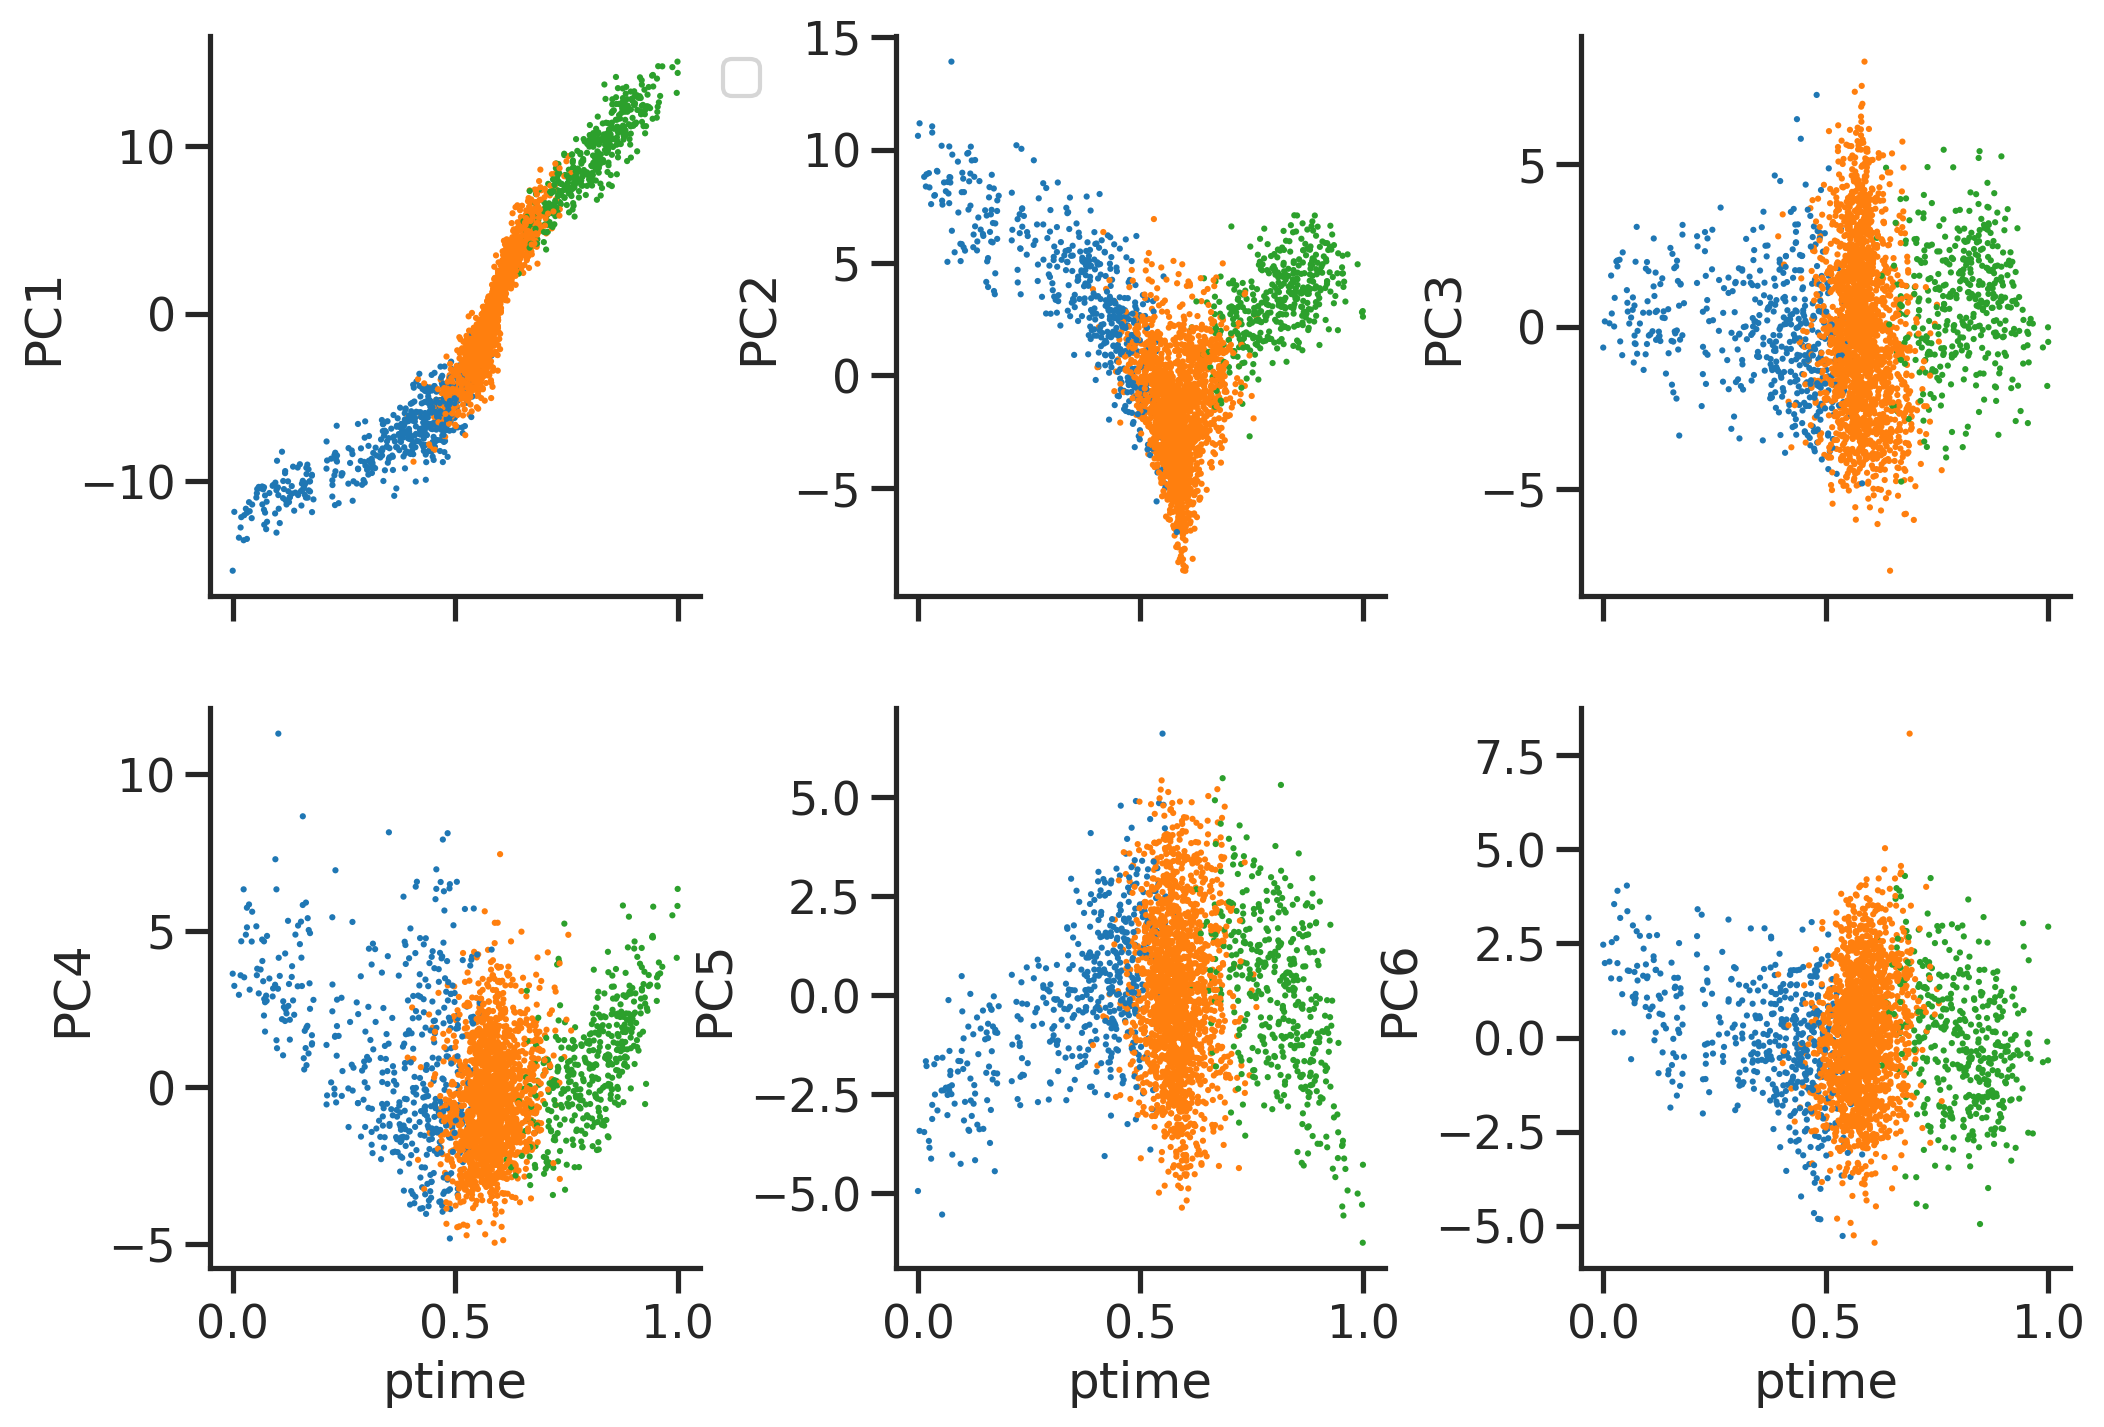

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(4*3,4*2), sharex=True)
for i, ax in enumerate(axs.flat):
    sns.scatterplot(data=res, 
                    x='ptime',
                    y=f'PC{i+1}',
                    hue='type',
                    edgecolor='none',
                    s=5,
                    ax=ax,
                    legend=False,
                   )
    ax.grid(False)
    sns.despine(ax=ax)
axs.flat[0].legend(bbox_to_anchor=(1,1), loc='upper left')
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
fig.subplots_adjust(wspace=0.4)
plt.show()

03-28 14:05:51 - maxp pruned
03-28 14:05:51 - cmap pruned
03-28 14:05:51 - kern dropped
03-28 14:05:51 - post pruned
03-28 14:05:51 - FFTM dropped
03-28 14:05:51 - GPOS pruned
03-28 14:05:51 - GSUB pruned
03-28 14:05:51 - name pruned
03-28 14:05:51 - glyf pruned
03-28 14:05:51 - Added gid0 to subset
03-28 14:05:51 - Added first four glyphs to subset
03-28 14:05:51 - Closing glyph list over 'GSUB': 34 glyphs before
03-28 14:05:51 - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'G', 'N', 'P', 'R', 'a', 'c', 'e', 'eight', 'five', 'g', 'k', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'space', 't', 'three', 'two', 'y', 'z', 'zero']
03-28 14:05:51 - Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 24, 27, 36, 37, 38, 42, 49, 51, 53, 68, 70, 72, 74, 78, 79, 80, 81, 82, 83, 85, 86, 87, 92, 93, 3228]
03-28 14:05:51 - Closed glyph list over 'GSUB': 34 glyphs after
03-28 14:05:51 - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'G', 'N', 'P', 'R', 'a', 'c', 

saved the figure to: /scr/qlyu/projects/v1/figures/heatmap_P38NR_v4_2023-03-28.pdf


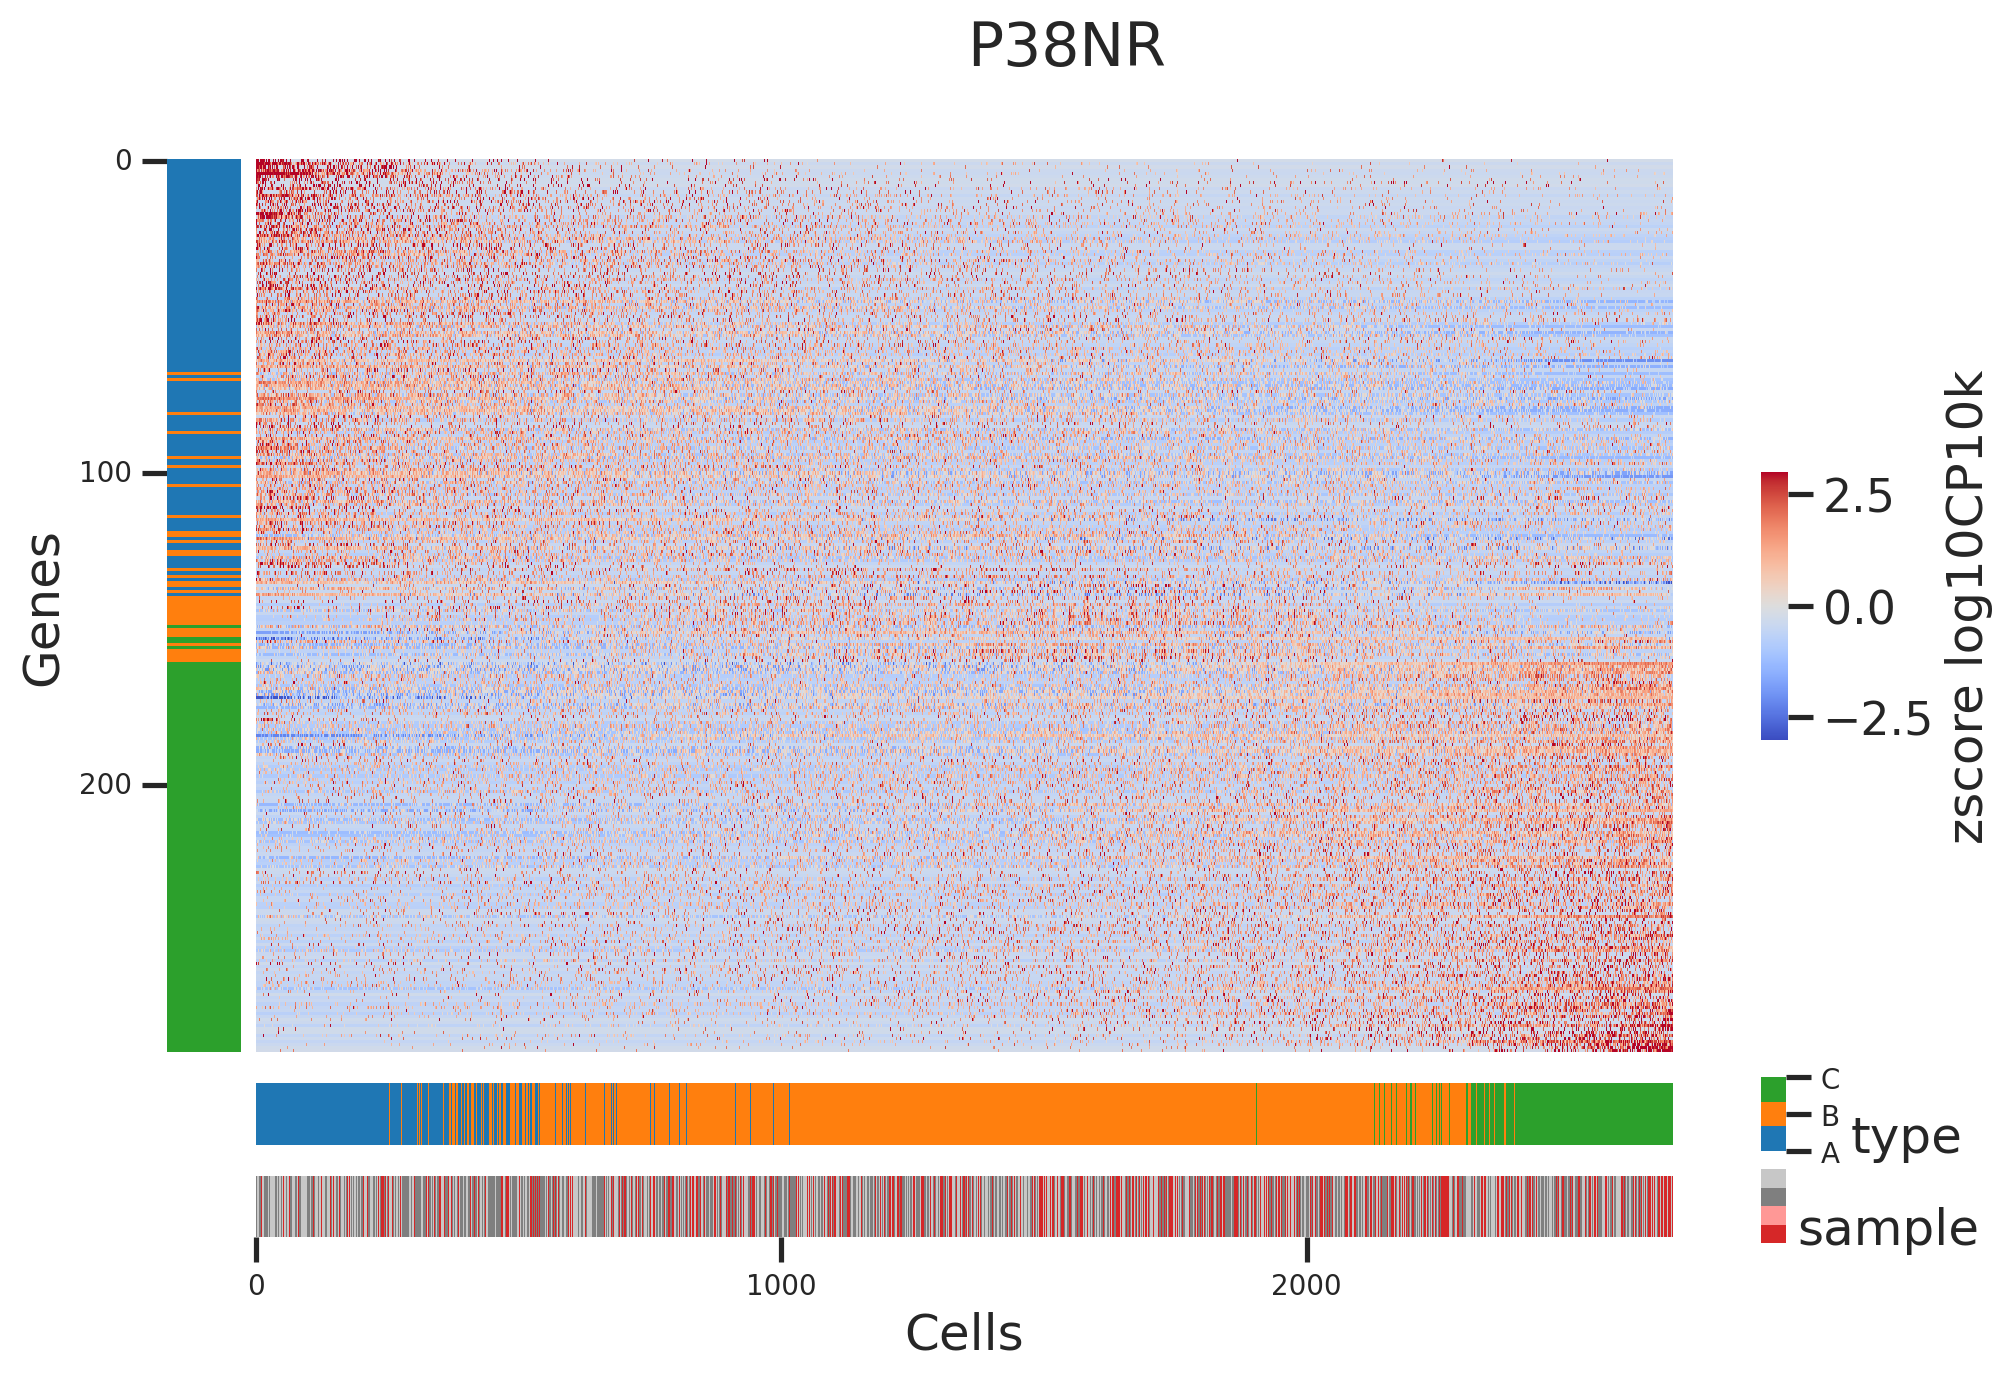

In [22]:

mosaic = ("B"+"A"*20+"\n")*10 + ("."+"C"*20+"\n") + ("."+"D"*20+"\n")
# print(mosaic)

fig, axdict = plt.subplot_mosaic(mosaic, figsize=(12,7))
ax = axdict['A']
sns.heatmap(zlognorm[cellidx][:,geneidx2].T,
            xticklabels=False,
            yticklabels=False,
            cbar_kws=dict(shrink=0.3, label='zscore log10CP10k', aspect=10),
            center=0,
            vmax=3,
            vmin=-3,
            cmap='coolwarm',
            rasterized=True,
            ax=ax,
           )

ax = axdict['B']
sns.heatmap(pd.factorize(genes_grp[geneidx2], sort=True)[0].reshape(-1,1), 
            xticklabels=False,
            yticklabels=100,
            cmap=cmap_d1,
            cbar=False,
            rasterized=True,
            ax=ax, 
           )
ax.set_ylabel('Genes')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

ax = axdict['C']
sns.heatmap(pd.factorize(types[cellidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=False,
            yticklabels=False,
            cmap=cmap_d1,
            cbar_kws=dict(ticks=[0,1,2], shrink=1.2, aspect=3, label='type'),
            rasterized=True,
            ax=ax, 
           )
fig.axes[-1].set_yticklabels(['A','B','C'], fontsize=10)
fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')

ax = axdict['D']
sns.heatmap(pd.factorize(samps[cellidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=1000,
            yticklabels=False,
            cmap=cmap_d2,
            cbar_kws=dict(ticks=[], shrink=1.2, aspect=3, label='sample'),
            rasterized=True,
            ax=ax, 
           )
ax.set_xlabel('Cells')
fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

fig.subplots_adjust(hspace=0.5)
fig.suptitle(sample)
powerplots.savefig_autodate(fig, os.path.join(outdir_fig, f'heatmap_{sample}_v4.pdf'))
plt.show()

In [23]:
# save ptime info

In [24]:
res.index = adata.obs.index
res

PC1       PC2       PC3       PC4  \
AAACCCAAGTGACACG-1-P38_1a-P38  -4.749819  2.116440  4.372878  0.801553   
AAAGGATAGCCATTGT-1-P38_1a-P38   0.187862 -1.113316  2.812910 -2.726155   
AAAGGATGTAAGAACT-1-P38_1a-P38  10.096123  3.328336  0.872992  2.320638   
AAAGGATTCTCGCGTT-1-P38_1a-P38  -3.973735 -7.596762  1.117839  3.997468   
AAAGGGCAGCCGTCGT-1-P38_1a-P38  -0.410447 -1.124055 -0.554808 -1.724379   
...                                  ...       ...       ...       ...   
TTTGGAGGTCCGGACT-1-P38_2b-P38  -2.067182  1.827468 -0.357348 -3.028944   
TTTGGTTAGTAGTCAA-1-P38_2b-P38  -4.067961  1.202213 -3.571057 -1.494378   
TTTGGTTGTACGTGAG-1-P38_2b-P38  -9.609977  5.112622  1.797906  2.566884   
TTTGGTTTCTCCGTGT-1-P38_2b-P38  -5.945409  2.203461 -1.027048 -1.436030   
TTTGTTGTCCATGATG-1-P38_2b-P38   1.743903 -1.178493  0.341986 -2.588522   

                                    PC5       PC6       PC7       PC8  \
AAACCCAAGTGACACG-1-P38_1a-P38  1.804032 -0.777670  4.017456 -1.206675   
AAAGGATAGCCATTGT-1-P38_1a-P38  0.486070 -0.239934 -0.188671 -2.050115   
AAAGGATGTAAGAACT-1-P38_1a-P38 -0.424083  2.148678  0.125508 -0.585514   
AAAGGATTCTCGCGTT-1-P38_1a-P38 -0.120642 -0.167397 -2.018058 -0.138114   
AAAGGGCAGCCGTCGT-1-P38_1a-P38 -0.107836 -0.108609  0.128114 -0.279375   
...                                 ...       ...       ...       ...   
TTTGGAGGTCCGGACT-1-P38_2b-P38 -1.460341 -0.863849 -1.219213  0.706270   
TTTGGTTAGTAGTCAA-1-P38_2b-P38 -0.697248 -2.024185  1.028850 -0.682947   
TTTGGTTGTACGTGAG-1-P38_2b-P38 -1.014856  0.897299  1.352017 -2.540948   
TTTGGTTTCTCCGTGT-1-P38_2b-P38 -2.044638 -0.885287 -0.725214 -1.123299   
TTTGTTGTCCATGATG-1-P38_2b-P38 -1.263861 -1.527266 -0.677189 -0.875770   

                                    PC9      PC10  ...      PC46      PC47  \
AAACCCAAGTGACACG-1-P38_1a-P38  0.383534  1.769066  ... -2.468380 -1.381974   
AAAGGATAGCCATTGT-1-P38_1a-P38 -1.614670 -1.864122  ...  0.270547 -1.193993   
AAAGGATGTAAGAACT-1-P38_1a-P38 -0.382442 -2.957246  ... -1.537727 -1.261839   
AAAGGATTCTCGCGTT-1-P38_1a-P38 -0.570401  1.528471  ...  0.876582  0.626988   
AAAGGGCAGCCGTCGT-1-P38_1a-P38  0.532636  0.866133  ... -0.206472 -0.522356   
...                                 ...       ...  ...       ...       ...   
TTTGGAGGTCCGGACT-1-P38_2b-P38 -0.364829  0.330943  ...  0.854086 -1.348163   
TTTGGTTAGTAGTCAA-1-P38_2b-P38  0.294291 -0.189152  ... -0.627747 -0.202214   
TTTGGTTGTACGTGAG-1-P38_2b-P38  0.166630 -2.383431  ...  1.854205 -1.679918   
TTTGGTTTCTCCGTGT-1-P38_2b-P38 -0.269469 -1.307279  ... -0.160521  0.423041   
TTTGTTGTCCATGATG-1-P38_2b-P38  1.757696 -1.707292  ... -0.794368 -0.905922   

                                   PC48      PC49      PC50    type    samp  \
AAACCCAAGTGACACG-1-P38_1a-P38  0.461245 -2.168014  1.511427  L2/3_B  P38_1a   
AAAGGATAGCCATTGT-1-P38_1a-P38  0.914216  0.195245  0.710182  L2/3_B  P38_1a   
AAAGGATGTAAGAACT-1-P38_1a-P38  0.440760  0.369733 -1.180382  L2/3_C  P38_1a   
AAAGGATTCTCGCGTT-1-P38_1a-P38 -0.459106  0.880790  1.019466  L2/3_B  P38_1a   
AAAGGGCAGCCGTCGT-1-P38_1a-P38 -0.044421 -0.804204 -0.197926  L2/3_B  P38_1a   
...                                 ...       ...       ...     ...     ...   
TTTGGAGGTCCGGACT-1-P38_2b-P38  0.781665  1.135923 -1.025656  L2/3_B  P38_2b   
TTTGGTTAGTAGTCAA-1-P38_2b-P38 -0.916435 -1.948392  0.576038  L2/3_B  P38_2b   
TTTGGTTGTACGTGAG-1-P38_2b-P38 -0.164417  0.722956 -1.978422  L2/3_A  P38_2b   
TTTGGTTTCTCCGTGT-1-P38_2b-P38 -0.447162  0.761870 -0.207671  L2/3_A  P38_2b   
TTTGTTGTCCATGATG-1-P38_2b-P38 -1.695149 -0.199386 -0.225345  L2/3_B  P38_2b   

                                  umap1     umap2     ptime  
AAACCCAAGTGACACG-1-P38_1a-P38  1.475724  1.645475  0.495914  
AAAGGATAGCCATTGT-1-P38_1a-P38  2.624625 -0.028892  0.576554  
AAAGGATGTAAGAACT-1-P38_1a-P38  7.535295  0.206604  0.822993  
AAAGGATTCTCGCGTT-1-P38_1a-P38  1.292565 -0.846325  0.580326  
AAAGGGCAGCCGTCGT-1-P38_1a-P38  3.203928  1.256592  0.564102  
...          

In [25]:
fout = f"/scr/qlyu/projects/v1/results/cell_ptime_{sample}_L23_Mar28.tsv"
res.index = adata.obs.index
res.to_csv(fout, header=True, index=True)